In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 


# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

### Now use MD Analysis to calculate no. of frames a center PLGA residues and terminal PLGA residue is with 4 Angstroms of BSA (1.2 nm restrained system)

Import MDAnalysis

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import MDAnalysis.analysis.distances as maa_dist

Load the rg = 1.2 nm (3 PLGA N = 20 oligomer/BSA system) 

In [4]:
# Set up the MD Simulation
u_pn20 = mda.Universe("../1.2nm_bsa_prod/k4000_plumed/sys_conf.gro", "../1.2nm_bsa_prod/k4000_plumed/pp_sys.xtc")

In [5]:
u_pn20

<Universe with 10148 atoms>

Check that we are on the first frame

In [6]:
u_pn20.trajectory.frame

0

In [7]:
# Select the center PLGA residue atoms, heavy atoms only
pn20_cent = u_pn20.select_atoms("resname PLG and not type H")
pn20_cent

<AtomGroup with 486 atoms>

In [8]:
# Select the terminal PLGA residues, heavy atoms only 
pn20_term = u_pn20.select_atoms("resname sPLG tPLG and not type H")
pn20_term

<AtomGroup with 57 atoms>

In [9]:
#Select all the PLGA residues, heavy atoms only 
all_pn20 = u_pn20.select_atoms("resname sPLG PLG tPLG and not type H")
all_pn20

<AtomGroup with 543 atoms>

In [10]:
# Select BSA residues, heavy atoms only 
prot = u_pn20.select_atoms("protein and not type H")
prot

<AtomGroup with 4653 atoms>

In [11]:
# This code chunk gets the BSA residues and their corresponding number in a pandas dataframe 

red_bsa = []
bh = np.arange(0,584)
for i in range(583):
    b_str = str(list(prot.residues[i:i+1]))
    if str(bh[i+1]) in b_str: 
        red_bsa.append(str(b_str[10:13])+" "+str(bh[i+1]))
#red_bsa
rr = [row[0:3] for row in red_bsa]
nores = [row[4:9] for row in red_bsa] 
d = {'BSA_res_no': nores, 'BSA_res_des': rr}
res1_2nm = pd.DataFrame(data=d)
#res1_2nm

In [12]:
# This code calculates how many atoms are in each residue of BSA and stores it in a dictionary 

# When saving new keys and their associated values in a dictionary, make sure the key is not the 
# same as a key that has already been saved. The value that has been saved with the key will be erased and the newest
# value will be placed in the dictionary if trying to add new value with the same key into the dict

rb_atom = {}
for i in range(len(red_bsa)):     
    st_r = "resname "+str(red_bsa[i][0:3])+" and resid "+str(red_bsa[i][4:9])
    da = list(prot.select_atoms(st_r))
    rb_atom[st_r] = len(da)

#rb_atom

Visualize BSA contact map with a 8 Angstroms cutoff, Heavy atoms only

Text(0.5, 1.05, 'BSA Atomic Contact Map: PDB code 4F5S')

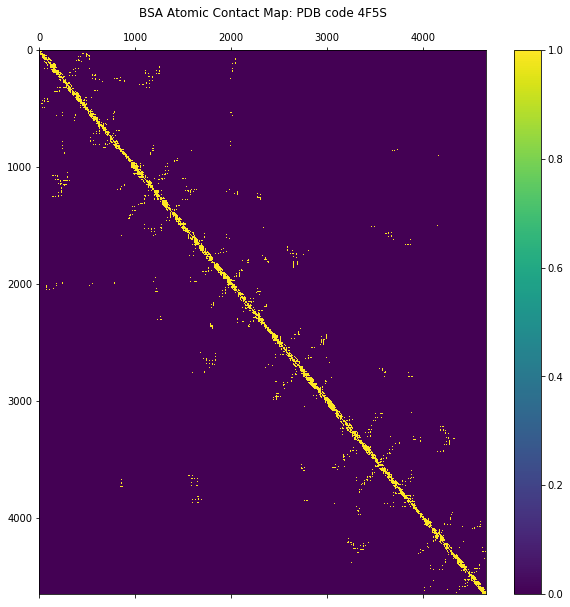

In [13]:
#Length units in MD Analysis is Angstroms, Using 8.5 A cutoff to better visualize atomic contacts
bs = maa_dist.contact_matrix(prot.positions,cutoff=7.5,box=u_pn20.dimensions)
fig, ax = plt.subplots(figsize=(10,10))
l_s = ax.matshow(bs.astype(int), aspect="auto")
fig.colorbar(l_s, ax=ax)
ax.set_title('BSA Atomic Contact Map: PDB code 4F5S')

### First table will be total fractional contacts and oligomer occupancy values for each Rg value 

#### Distance-based analysis 

Find residues that have at least one atom within a cutoff $d = 4.0$ Angstrom near PLGA residues in 1.2 nm

Calculate the number of surface bsa residues from a 1 ns BSA/water simulation

In [14]:
#Units of Angstroms 
dmax = 4.0 

In [ ]:
exp_bsa_atoms = np.any(dij_tri <= dmax, axis=1)

# Boolean arrays must be of the same shape as the initial dimensions of the array being indexed.
# In the most straightforward case, the boolean array has the same shape
# Unlike in the case of integer index arrays, in the boolean case,
# the result is a 1-D array containing all the elements in the indexed array corresponding
#       to all the true elements in the boolean array.

bres_wit_dmax = prot[exp_bsa_atoms].residues

In [15]:
## Define a function that does this, Courtesy of MDAnalysis tutorial 
def get_residues_dist(prot_atoms, g2_atoms, dmax, universe):
    """Find all protein residues for which atoms that are within dmax"""
    ro = len(prot_atoms)
    cl = len(g2_atoms)
    dij_tri = np.zeros(shape=(ro,cl))
    dij_tri = maa_dist.distance_array(prot_atoms.positions, g2_atoms.positions, box=universe.trajectory.ts.dimensions)
    exp_prot_atoms = np.any(dij_tri <= dmax, axis=1)
    mk = list(prot_atoms[exp_prot_atoms].residues)
    return mk

In [16]:
# Define a function that outputs a dictionary of AA protein number and frame counts, where 
# the inputs will be number of frames, universe, prot and group 2 atom group, and dmax 
# Write function that takes a no of total frames, protein atom positions and group 2 atoms positions 
# and gives a dictionary of protein AA as keys and frame count as values 

def aa_frmcount(prot_atoms, g2_atoms, dmax, universe, frames):
    """This function will output a dictionary of AA protein number and its corresponding frame count"""
    
    aa_dict = {}
    
    for ts in universe.trajectory[0:frames]: 
        count = 0
        bsres = get_residues_dist(prot_atoms, g2_atoms, dmax, universe)
        laa = list(prot_atoms.residues)
    
        if bool(bsres) == False: 
            pass
        elif bool(bsres) != False: 
            count += 1
            for i in range(len(bsres)):
                for j in range(len(laa)): 
                    if laa[j] == bsres[i]:
                        if bool(aa_dict) == False:
                            aa_dict[laa[j]] = count 
                        elif bool(aa_dict) != False: 
                            b = list(aa_dict.keys())
                            if laa[j] in b: 
                                nw = int(aa_dict[laa[j]]) + count
                                aa_dict[laa[j]] = nw
                            elif laa[j] not in b:
                                aa_dict[laa[j]] = count
    
    gg_new = {str(key):value for key,value in aa_dict.items()}
    
    return gg_new 


In [ ]:
def AA_list_org(lorg_list):
    
    hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
    polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
    neg_res = ['ASP', 'GLU']
    pos_res = ['ARG', 'HIS', 'LYS']

    all_res = [pos_res, neg_res, polar_res, hydrophobic_res]
    #Change order of residues before making the bar graph
    # (1) Positively charged
    # (2) Negatively charged
    # (3) Polar residues 
    # (4) Hydrophobic residues 
    
    # This chunk of code sorts the counts of each AA that have 1001 or 1002 frame count based 
    # on the AA order in all_res
    arr_list = []

    for row in all_res:
        for i in range(len(lorg_list)):
            for j in range(len(row)):
                if row[j] == lorg_list[i][0:3]:
                    arr_list.append(lorg_list[i])
                    
    #This chunk of code splits the list arr_list to makes the AA: count of 1001 or 1002 frames data plottable 
    f_list = []
    fn_list = []
    for i in range(len(arr_list)):
        f_list.append(arr_list[i][0:3])
        fn_list.append(int(arr_list[i][5:7]))
        
    return f_list, fn_list

In [18]:
# Read in data from the oputput of wrapper.sh, where the frame count is given for each BSA residue that was within 
# 4 angstroms of PLGA trimer 
wat_data = pd.read_csv('occ_BSA1ns.txt', sep=" ", header=None, usecols=None ,index_col=None)
wat_data.columns = ["BSA_res_no","No. of frames (VMD)"]
wat_data = wat_data.drop("BSA_res_no", axis=1)
wat_data['BSA_des_res'] = list(prot.residues)
wat_data = wat_data[['BSA_des_res',"No. of frames (VMD)"]]
wat_data.head()

,BSA_des_res,No. of frames (VMD)
0,"<Residue ASP, 1>",1002
1,"<Residue THR, 2>",1002
2,"<Residue HIS, 3>",1002
3,"<Residue LYS, 4>",1002
4,"<Residue SER, 5>",1002


Now load BSA/water trajectory to compare the frame counts values from VMD 

In [19]:
# Load universe of the BSA/water simulation
bsa_wat = mda.Universe("../bsa_analysis/tout_local/confout.gro", "../bsa_analysis/tout_local/traj_comp.xtc")

In [20]:
# Check Universe 
bsa_wat

<Universe with 138239 atoms>

In [26]:
# Check Trajectory Length 
bstrj = len(bsa_wat.trajectory)

In [22]:
# Load protein atoms, heavy atoms only 
wb_prot = bsa_wat.select_atoms("protein")

In [23]:
wb_prot

<AtomGroup with 9220 atoms>

In [24]:
# Load water atoms
hto_atms = bsa_wat.select_atoms("resname SOL")

In [25]:
hto_atms

<AtomGroup with 129003 atoms>

In [27]:
# Create dictionary of BSA residues and frame count, DO NOT EXECUTE, WILL TAKE TOO LONG WITH SOL GROUP > 100K ATOMS
#h2ob_dict = aa_frmcount(wb_prot, hto_atms, dmax, bsa_wat, bstrj)

In [33]:
# Change this cell to load in save dictionary text file into pandas dataframe 
import json

with open('MDA_BSA1ns.txt', 'w') as file:
     file.write(json.dumps(gg_new))

In [36]:
wat_data['Mda_frames'] = wat_data['BSA_des_res'].map(h2ob_dict)
wat_data.head()
# Need to ask about whether 900 frames or greater still works for surface residue requirement 

,BSA_des_res,No. of frames (VMD),Mda_frames
0,"<Residue ASP, 1>",1002,1001
1,"<Residue THR, 2>",1002,1001
2,"<Residue HIS, 3>",1002,1001
3,"<Residue LYS, 4>",1002,1001
4,"<Residue SER, 5>",1002,1001


In [ ]:
# Check if there are non matching values between the VMD and MDAnalysis values 
for index, row in wat_data.iterrows():
    if 
    elif row["No. of frames (VMD)"] == row["Mda_frames"]: 
        print(wat_data.loc[index])
        
# Only 24 BSA AA residue frame count match those calculated from vmd 

In [34]:
a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]

In [49]:
type(wat_data["BSA_des_res"].loc[0])

MDAnalysis.core.groups.Residue

In [62]:
wat_data["BSA_des_res"] = red_bsa
wat_data.tail()

,BSA_des_res,No. of frames (VMD),Mda_frames
578,GLN 579,1002,1001
579,THR 580,1002,1001
580,ALA 581,1002,1001
581,LEU 582,1002,1001
582,ALA 583,0,1001


In [64]:
wat_data.loc[180]

BSA_des_res            ILE 181
No. of frames (VMD)       1001
Mda_frames                1000
Name: 180, dtype: object

In [70]:
# From MD Analysis
#Get the count of bsa residues that have 1001 or 1002 frames ( I ran a 1 ns NPT simulation of 1 BSA in water )

#aa_count = pd.DataFrame(data=a_a)
c_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in wat_data.iterrows():
        if a_a[i] in row["BSA_des_res"]:
            if row['Mda_frames'] == 1001: 
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row['Mda_frames'] == 1000:
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    c_list.append(str(str(a_a[i])+"  "+str(count)))
    
#c_list

In [71]:
# From VMD
#Get the count of bsa residues that have 1001 or 1002 frames ( I ran a 1 ns NPT simulation of 1 BSA in water )

#aa_count = pd.DataFrame(data=a_a)
vmd_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in wat_data.iterrows():
        if a_a[i] in row["BSA_des_res"]:
            if row["No. of frames (VMD)"] == 1001: 
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row["No. of frames (VMD)"] == 1002:
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    vmd_list.append(str(str(a_a[i])+"  "+str(count)))

# Main difference is that Alanine 583 is counted for all 1001 frames. It seems VMD is able to calc dist for that res
#vmd_list

In [80]:
# Put the AA count in a pandas dataframe 
dg , ji = AA_list_org(c_list)
aa_count = pd.DataFrame(data=dg, index=None, columns=['Amino_acids'])
new_lf = pd.Series(data=ji, index=None)
vmg, vmdj = AA_list_org(vmd_list)
n2lf = pd.Series(data=vmdj, index=None)
aa_count['No_of_surf_res (MDAnalysis)'] = new_lf
aa_count['No_of_surf_res (VMD)'] = n2lf
aa_count

,Amino_acids,No_of_surf_res (MDAnalysis),No_of_surf_res (VMD)
0,LYS,59,59
1,ARG,23,23
2,HIS,16,16
3,ASP,40,40
4,GLU,59,59
5,SER,23,23
6,THR,29,29
7,CYS,24,24
8,TYR,19,19
9,ASN,14,14


In [ ]:
#plotting 
#Change order of residues before making the bar graph
# (!) Positively charged
# (2) Negatively charged
# (3) Polar residues 
# (4) Hydrophobic residues 
x = np.arange(20)
leg = ['Positively Charged', 'Negatively Charged', 'Polar', 'Hydrophobic']
plt.figure(figsize=(10,8))
plt.bar(x[0:3], aa_count['No. of surf. res.'][0:3], color='blue')
plt.bar(x[3:5], aa_count['No. of surf. res.'][3:5], color='red')
plt.bar(x[5:11], aa_count['No. of surf. res.'][5:11], color='magenta')
plt.bar(x[11:20], aa_count['No. of surf. res.'][11:20], color='cyan')
plt.xticks(x,aa_count['Amino_acids'])
plt.legend(leg)

### Now to finally calculate total fraction of contacts for 1.2 nm Rg trajectory 

Load the rg = 1.2 nm (3 PLGA N = 20 oligomer/BSA system) 

In [ ]:
apl_list = []

# Some residues don't have any contact with PLGA trimers within 25 ns, put residues that do have contact with BSA in a separate list
for index, r_pl in pl_25ns_data.iterrows():
    if r_pl['No_of_frames(PLGA trimer)'] != 0:
        apl_list.append(r_pl['BSA_res_des_order'])

        
# This chunk of code gets an AA count from the above list, in order to get a total number of residues that contact BSA
cpl_l = []

for index, r_a in aa_count.iterrows():
    count = 0
    for i in range(len(apl_list)):
        if apl_list[i] == r_a['Amino_acids']:
            count += 1
    cpl_l.append(count)      
        
aa_count['PLGA_trimer_25ns_SR'] = cpl_l
aa_count

In [ ]:
# This gives the total number of residues that are within 4 angstroms of PLGA trimers within a 25 ns block. 
# All other residues were not within 4 A over the course of the 25 ns trajectory block 
aa_count['PLGA_trimer_25ns_SR'].sum()

In [ ]:
# This gives the total number of residues that are within 4 angstroms of a water molecule within a 1 ns trajectory block
aa_count['No. of surf. res.'].sum()

Write a function that calculates the average total fraction of contacts and average occupancy (No of residues contacted by PLGA oilgs/total no of surface residues) and their standard deviations for a given number of trajectory blocks 

Write function that takes frame count and AA protein residue list (or dictionary) and gives 

1) AA count of residues that are in contact with polymer (1 output file) 
2) frame count, type of contact, normalized contact, and fractional contacts (1 output file) 